# Butterfly example

*Produces Figure (6) & (7)*

### Affiliations & E-mails
Flavio Lorez: [florez@ethz.ch](mailto:florez@ethz.ch)

¹: Computational Mechanics of Building Materials, ETH Zurich, Switzerland. 

### Environment setup
Special dependencies to run this notebook:
- `h5py` (and the HDF5 library)
- `mpi4py`
- `bamboost`, a python library built at CMBM for data management using HDF5.

To install `bamboost`:

```bash
git clone https://gitlab.ethz.ch/compmechmat/research/libs/bamboost.git
cd bamboost
pip install .
```
Alternatively to using `pip`, you can append the system path to find the package.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from bamboost import Manager

import utilities

In [15]:
database_path = '../out-butterfly/'
db = Manager(database_path)
db

In [17]:
sim = db['535c4bab']
sim

### Figure of von Mises stress

In [35]:
utilities.set_plot_theme()
plt.rcParams['lines.linewidth'] = 1

# Initial configuration
disk_center = sim.parameters['disk_pos']
eps = sim.parameters['eps']
r0 = 1.85
coords = sim.mesh[0]
disk_phi_smaller = .5*(1-np.tanh((np.sqrt(
    (coords[:, 0] - disk_center[0])**2 + (coords[:, 1] - disk_center[1])**2) 
    - r0)/np.sqrt(2) / eps))

# -----------------------------------------------------------------------------

def plot_step(ax, step, cmap):

    n = 50

    def data(field, step, threshold=None):
        """Loads the data and filters it to where phi>0.5 and
        mirrors it along the right axis to create the full butterfly.
        """
        arr = sim.data[field].at_step(step)
        if step==0:
            arr = np.zeros_like(arr)
        if threshold is not None:
            phi = sim.data[f"{field.split('_')[0]}_phi"].at_step(step)
            arr *= phi
            # arr[phi<.05] = -.05+phi[phi<.05]
            arr[phi<.5] = 0
        arr = np.vstack((arr, arr))
        return arr
    
    # Load the coordinates, and mirror it along the right edge (x=20)
    coords = np.vstack((sim.mesh[0], np.array([20, 0]) + np.array([-1, 1])*sim.mesh[0]))
    
    # Plot the butterfly von Mises stresses
    colorbar_field = ax.tricontourf(
        *coords.T,
        data('butter_vonMises', step, 0.5).flatten(),
        levels=np.linspace(0, 0.05, n),
        cmap=cmap,
        antialiased=True,
        extend='max',
        vmin=0,
        vmax=.05,
    )
    for col in colorbar_field.collections:
        col.set_rasterized(True)

    # Plot the disk von Mises stresses
    tri = ax.tricontourf(
        *coords.T,
        data('disk_vonMises', step, 0.5).flatten(),
        levels=np.linspace(0, 0.05, n),
        cmap=cmap,
        antialiased=True,
        extend='max',
        vmin=0,
        vmax=.05,
    )
    for col in tri.collections:
        col.set_rasterized(True)

    # Load phi to plot the black background
    bg = sim.data['butter_phi'].at_step(step)
    bg = np.vstack((bg, bg)).flatten()
    
    # create cmap (white -> transparent)
    c = [(1, 1, 1, 0), (1, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1)]
    v = [0, .4, .6, 1]
    l = list(zip(v,c))
    white_transparent=mpl.colors.LinearSegmentedColormap.from_list('whites',l, N=4)
    tri = ax.tricontourf(*coords.T, bg, levels=2, cmap=white_transparent, zorder=-1, vmax=1.001, extend='max')
    for col in tri.collections:
        col.set_rasterized(True)
    
    if step!=0:
        data = data('disk_phi', step).flatten()
    else:
        data = np.hstack((disk_phi_smaller, disk_phi_smaller)).flatten()
    tri = ax.tricontourf(*coords.T, data, cmap=white_transparent, levels=2, zorder=-1, vmax=1.001)
    for col in tri.collections:
        col.set_rasterized(True)

    ax.set_aspect('equal')
    ax.set(xticks=[], yticks=[])
    ax.set_facecolor('white')
    
    return colorbar_field
    
# -----------------------------------------------------------------------------
    
# Figure setup
fig = plt.figure(figsize=(7.0, 3.5))
gs = mpl.gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
bx = fig.add_subplot(gs[0, 1])
cx = fig.add_subplot(gs[0, 2])

cmap = plt.cm.RdBu_r
cmap_creator=cmap(np.arange(cmap.N))
cmap_creator[20:, -1] = np.linspace(0.3, 1, cmap.N-20)
cmap_creator[:20, -1] = np.linspace(0, .3, 20)
cmap_creator[0, -1] = 0
my_cmap = mpl.colors.ListedColormap(cmap_creator)

# Plot the 3 steps
plot_step(ax, 0, my_cmap)
plot_step(bx, 24, my_cmap)
cb = plot_step(cx, 49, my_cmap)

plt.tight_layout(pad=0, w_pad=1)

# Add colorbar
cbax = fig.add_axes((cx.get_position().x1+(cx.get_position().x0-bx.get_position().x1) * .5, cx.get_position().y0,
                     0.01, cx.get_position().height))
cb = fig.colorbar(cb, cax=cbax, extend='neither', extendrect=True)
cb.set_label('$\sigma_V/E$', labelpad=-3)
cb.set_ticks([0, 0.05])
cb.ax.set_ylim((0, 5e-2))
cb.ax.set_facecolor('k')
cb.formatter.set_powerlimits((0,0))

fig.savefig('figs/figure_butterfly.pdf', dpi=1000, bbox_inches='tight', pad_inches=.012)

### Schematic figure

In [20]:
utilities.set_plot_theme()
plt.rcParams['lines.linewidth'] = 1.

def cmap_hot_and_cold():
    from matplotlib.colors import LinearSegmentedColormap
    c = [(0, 1, 1, 1), (0, 0, 1, 1), (0, 0, 0.50196, 1), (1, 0, 0, 1), (1, 1, 0, 1.)]
    v = [0, .45, .5, 0.55, 1.]
    l = list(zip(v,c))
    hotcold=LinearSegmentedColormap.from_list('Hot and Cold',l, N=256)
    return hotcold

In [27]:
# Initial configuration
disk_center = sim.parameters['disk_pos']
eps = sim.parameters['eps']
r0 = 1.5

coords = sim.mesh[0]
disk_phi_smaller = .5*(1-np.tanh((np.sqrt((coords[:, 0] - disk_center[0])**2 + (coords[:, 1] - disk_center[1])**2) - r0)/np.sqrt(2) / eps))

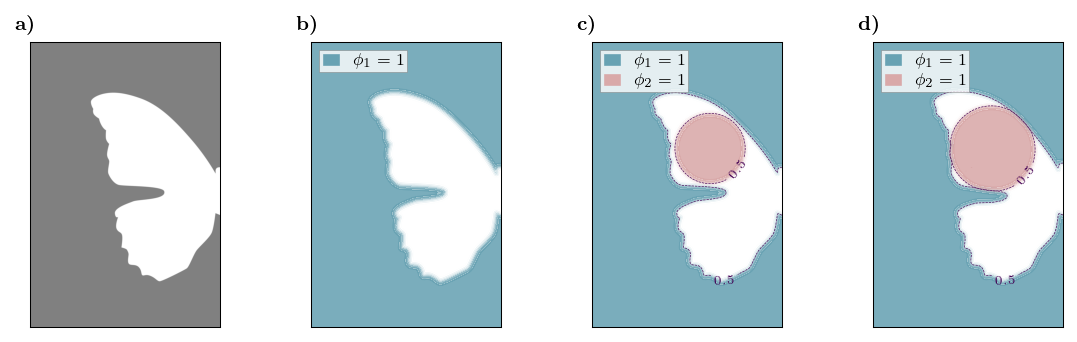

In [32]:
# Figure setup
fig = plt.figure(figsize=(7.4, 3.4))
axes = fig.subplots(1, 4, )
fig.tight_layout(w_pad=3)
fig_ratio = fig.get_size_inches()[0]/fig.get_size_inches()[1]

for ax, label in zip(axes, ('a', 'b', 'c', 'd')):
    ax.set(xticks=[], yticks=[])
    utilities.subplot_label(ax, label, -.1, )
    pos = ax.get_position().bounds
    ax.set_position((pos[0], pos[1], pos[2], 1.5*pos[2]*fig_ratio))

# -----------------------------------------------------------------------------

# Subfigure (a)
binary_image = plt.imread('../meshes-used/butterfly2.png')
axes[0].imshow(binary_image, alpha=0.5)

blue, red = '#68a2b3ff', '#d9a9a9ff'
def cmap_uni(color, color_negative='#ffffff00'):
    color_negative = list(color); color_negative[-2:] = ['0','0']; color_negative = "".join(color_negative)
    c = [color_negative, color]
    v = [0, 1]
    return mpl.colors.LinearSegmentedColormap.from_list('Uni', list(zip(v,c)), N=256)

# -----------------------------------------------------------------------------

# Subfigure (b)
sub_index = 1  # subplot index

# Load the data
butter_phi = sim.data['butter_phi'].at_step(0).flatten()
coords = sim.mesh[0]

# Plot butterfly
tri = axes[sub_index].tricontour(*coords.T, butter_phi, cmap=cmap_uni(blue), levels=np.linspace(0, 1.0001, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
for col in tri.collections:
    col.set_rasterized(True)
tri = axes[sub_index].tricontourf(*coords.T, butter_phi,
                                  cmap=cmap_uni(blue), levels=np.linspace(.5, 1.001, 5))

axes[sub_index].legend(handles=[mpl.patches.Patch(color=blue, label=r'$\phi_1=1$')], fancybox=False, loc='upper left')

# -----------------------------------------------------------------------------

# Subfigure (c)
sub_index = 2
disk_phi = disk_phi_smaller

# BUTTERFLY
tri = axes[sub_index].tricontour(*coords.T, butter_phi, cmap=cmap_uni(blue), levels=np.linspace(0, 1.0001, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
for col in tri.collections: col.set_rasterized(True)
tri = axes[sub_index].tricontourf(*coords.T, butter_phi,
                                  cmap=cmap_uni(blue), levels=np.linspace(.5, 1.001, 5))
CS = axes[sub_index].tricontour(*coords.T, butter_phi, levels=[.5], linestyles='--', linewidths=.3)
plt.clabel(CS, inline=1, fontsize=6, manual=[(7.5, 1)])

# DISK
tri = axes[sub_index].tricontour(*coords.T, disk_phi, cmap=cmap_uni(red), levels=np.linspace(0, 1.0001, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
tri = axes[sub_index].tricontourf(*coords.T, disk_phi, cmap=cmap_uni(red), levels=np.linspace(.5, 1.001, 5))
for col in tri.collections: col.set_rasterized(True)
CS = axes[sub_index].tricontour(*coords.T, disk_phi, levels=[.5], linestyles='--', linewidths=.3)
plt.clabel(CS, inline=1, fontsize=6, manual=[(8, 8)])

# LEGEND
axes[sub_index].legend(handles=[mpl.patches.Patch(color=blue, label=r'$\phi_1=1$'),
                                mpl.patches.Patch(color=red, label=r'$\phi_2=1$')],
                                fancybox=False, loc='upper left')

# -----------------------------------------------------------------------------

# Subfigure (d)
sub_index = 3
butter_phi = sim.data['butter_phi'].at_step(25).flatten()
disk_phi = sim.data['disk_phi'].at_step(25).flatten()

# BUTTERFLY
tri = axes[sub_index].tricontour(*coords.T, butter_phi, cmap=cmap_uni(blue), levels=np.linspace(0, 1.0001, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
for col in tri.collections: col.set_rasterized(True)
tri = axes[sub_index].tricontourf(*coords.T, butter_phi,
                                  cmap=cmap_uni(blue), levels=np.linspace(.5, 1.001, 5))
CS = axes[sub_index].tricontour(*coords.T, butter_phi, levels=[.5], linestyles='--', linewidths=.3)
plt.clabel(CS, inline=1, fontsize=6, manual=[(7.5, 1)])

# DISK
tri = axes[sub_index].tricontour(*coords.T, disk_phi, cmap=cmap_uni(red), levels=np.linspace(0, 1.01, 10),
                                 vmin=.1, vmax=.9, linewidths=.3)
tri = axes[sub_index].tricontourf(*coords.T, disk_phi, cmap=cmap_uni(red), levels=np.linspace(.5, 1.01, 5), extend='max')
for col in tri.collections: col.set_rasterized(True)
CS = axes[sub_index].tricontour(*coords.T, disk_phi, levels=[.5], linestyles='--', linewidths=.3)
plt.clabel(CS, inline=1, fontsize=6, manual=[(8, 8)])

# LEGEND
axes[sub_index].legend(handles=[mpl.patches.Patch(color=blue, label=r'$\phi_1=1$'),
                                mpl.patches.Patch(color=red, label=r'$\phi_2=1$')],
                                fancybox=False, loc='upper left')

# -----------------------------------------------------------------------------

fig.savefig('figs/figure_butterfly_schematic_revision.pdf', dpi=800, bbox_inches='tight', pad_inches=0.1)